# Installing the NAG library and running this notebook

This notebook depends on the NAG library for Python to run. Please read the instructions in the [Readme.md](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#install) file to download, install and obtain a licence for the library.

Instruction on how to run the notebook can be found [here](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#jupyter).

# Simple Nonlinear Least-Squares Fitting Example

This example demontrates how to fit data to a model using weighted nonlinear least-squares. 

**handle_solve_bxnl** (`e04gg`) is a bound-constrained nonlinear least squares trust region solver (BXNL) from the NAG optimization modelling suite aimed for small to medium-scale problems. It solves the problem:

$$
\begin{array}{ll}
{\underset{x \in \mathbb{R}^{n_{\text{var}}}}{minimize}\ } & 
\frac{1}{2} \sum_{i=1}^{n_{\text{res}}} w_i r_i(x)^2 + \frac{\sigma}{p}\|x\|^p_2\\
\text{subject to} & l_{x} \leq x \leq u_{x}
\end{array}
$$


where $r_i(x),i=1,\dots,n_{\text{res}}$, are smooth nonlinear functions called residuals, $w_i ,i=1,\dots,n_{\text{res}}$ are weights (by default they are all defined to 1, and the rightmost element represents the regularization term with parameter $\sigma\geq0$ and power $p>0$. The constraint elements $l_x$ and $u_x$ are $n_{\text{var}}$-dimensional vectors defining the bounds on the variables.

Typically in a calibration or data fitting context, the residuals will be defined as the difference between the observed values $y_i$ at $t_i$ and the values provided by a nonlinear model $\phi(t;x)$, i.e., $$r_i(x)≔y_i-\phi(t_i;x).$$

The following example illustrates the usage of `e04gg` to fit PADC target with $\alpha$ particle
etched nuclear track data to a convoluted distribution. A target
sheet is scanned and track diameters (red wedges in
the following Figure 1) are recorded into a histogram and a mixed Normal and log-Normal model is to be fitted to the experimental histogram (see Figure 2).
![PADC](../images/tracks.png)


**Figure 1**: PADC with etched $\alpha$ particle tracks.

`e04gg` is used to fit the six parameter model
$$
\begin{array}{ll}
\phi\big(t, x = (a, b, A_{\ell}, \mu, \sigma, A_g)\big) = \text{log-Normal}(a, b, A_l) + \text{Normal}(\mu, \sigma^2, A_g)\\
\text{subject to } 0 \leq x,
\end{array}$$
using the histogram heights reported in Figure 2.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from naginterfaces.base import utils
from naginterfaces.library import opt

# problem data
# number of observations
nres = 64
# observations
diameter = range(1, nres+1)
density = [
     0.0722713864, 0.0575221239, 0.0604719764, 0.0405604720, 0.0317109145, 
     0.0309734513, 0.0258112094, 0.0228613569, 0.0213864307, 0.0213864307,
     0.0147492625, 0.0213864307, 0.0243362832, 0.0169616519, 0.0095870206,
     0.0147492625, 0.0140117994, 0.0132743363, 0.0147492625, 0.0140117994,
     0.0140117994, 0.0132743363, 0.0117994100, 0.0132743363, 0.0110619469,
     0.0103244838, 0.0117994100, 0.0117994100, 0.0147492625, 0.0110619469,
     0.0132743363, 0.0206489676, 0.0169616519, 0.0169616519, 0.0280235988,
     0.0221238938, 0.0235988201, 0.0221238938, 0.0206489676, 0.0228613569,
     0.0184365782, 0.0176991150, 0.0132743363, 0.0132743363, 0.0088495575,
     0.0095870206, 0.0073746313, 0.0110619469, 0.0036873156, 0.0051622419,
     0.0058997050, 0.0014749263, 0.0022123894, 0.0029498525, 0.0014749263,
     0.0007374631, 0.0014749263, 0.0014749263, 0.0007374631, 0.0000000000,
     0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000
     ]

# Define the data structure to be passed to the callback functions
data = {'d': diameter, 'y': density}

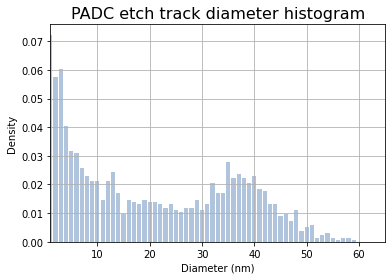

In [2]:
# Plot histogram of PADC etch track diameter count (densities)
dh = np.arange(1, 10*nres+9)/10.0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('PADC etch track diameter histogram', fontsize=16)
ax.set_xlabel('Diameter (nm)')
ax.set_ylabel('Density')
ax.set_xlim(xmin=1, xmax=65)
ax.bar(diameter, data['y'], color='lightsteelblue')
ax.grid()
plt.show()

**Figure 2**: Histogram of etched track diameter of $\alpha$ particles. Bar heights are the data that will be fitted unsing the aggregated model $\phi(x, t)$. 

In [3]:
# Define Normal and log-Normal distributions
def lognormal(d, a, b, Al):
    return Al/(d*b*np.sqrt(2*math.pi))*np.exp(-((np.log(d)-a)**2)/(2*b**2))

def gaussian(d, mu, sigma, Ag):
    return Ag*np.exp(-0.5*((d-mu)/sigma)**2)/(sigma*np.sqrt(2*math.pi))

In terms of solving this problem, the function to minimize is the sum of residuals using the model $\phi(x;t)$
and the data pair (`diameter`, `density`). The parameter vector is $x = (a, b, A_l, \mu, \sigma, A_g)$. The next step is to define a function to return the residual vector 
$\text{lsqfun}(x) := \big[r_1(x), r_2(x), \dots, r_{n_{\text{res}}}(x)\big]$.

In [4]:
# Define the least-square function as a mixture of Normal and log-Normal 
# functions. Also add its first derivatives
def lsqfun(x, nres, inform, data):
    """
    Objective function callback passed to the least squares solver.
    x = (a, b, Al, mu, sigma, Ag)
    """
    rx = np.zeros(nres)
    d = data['d']
    y = data['y']
    a = x[0]
    b = x[1]
    Al = x[2]
    mu = x[3]
    sigma = x[4]
    Ag = x[5]
    for i in range(nres):
        rx[i] = lognormal(d[i], a, b, Al) + gaussian(d[i], mu, sigma, Ag) - y[i]
    return rx, inform

def lsqgrd(x, nres, rdx, inform, data):
    """
    Computes the Jacobian of the least square residuals.
    x = (a, b, Al, mu, sigma, Ag)
    """
    n = len(x)
    d = data['d']
    a = x[0]
    b = x[1]
    Al = x[2]
    mu = x[3]
    sigma = x[4]
    Ag = x[5]
    for i in range(nres):
        # log-Normal derivatives
        l = lognormal(d[i], a, b, Al)
        # dl/da
        rdx[i*n+0] = (np.log(d[i])-a)/(b**2) * l
        # dl/db
        rdx[i*n+1] = ((np.log(d[i])-a)**2 - b**2)/b**3 * l
        # dl/dAl
        rdx[i*n+2] = lognormal(d[i], a, b, 1.0)
        # Gaussian derivatives
        g = gaussian(d[i], mu, sigma, Ag)
        # dg/dmu
        rdx[i*n+3] = (d[i] - mu) / sigma**2 * g
        # dg/dsigma
        rdx[i*n+4] = ((d[i] - mu)**2 - sigma**2)/sigma**3 * g
        # dg/dAg
        rdx[i*n+5] = gaussian(d[i], mu, sigma, 1.0)
    return rdx, inform

In [5]:
# parameter vector: x = (a, b, Al, mu, sigma, Ag)
nvar = 6

In [6]:
# Initialize the model handle
handle = opt.handle_init(nvar)

# Define a dense nonlinear least-squares objective function
opt.handle_set_nlnls(handle, nres)

In [7]:
# Add weights for each residual
weights = np.ones(nres)
weights[55:63] = 5.0
weights /= weights.sum()

# Define the reliability of the measurements (weights)
opt.handle_set_get_real(handle, 'rw', rarr=weights)

HandleSetGetRealReturnData(lrarr=64, rarr=None)

In [8]:
# Restrict parameter space (0 <= x)
opt.handle_set_simplebounds(handle, np.zeros(nvar), 100.0*np.ones(nvar))

In [9]:
# Set some optional parameters to control the output of the solver
for option in [
        'Print Options = NO',
        'Print Level = 1',
        'Print Solution = X',
        'Bxnl Iteration Limit = 100',
        'Bxnl Use weights = YES',
        # Add cubic regularization term (avoid overfitting)
        'Bxnl Reg Order = 3',
        'Bxnl Glob Method = REG',
]:
    opt.handle_opt_set(handle, option)

# Use an explicit I/O manager for abbreviated iteration output:
iom = utils.FileObjManager(locus_in_output=False)

In [10]:
# Define initial guess (starting point)
x = np.array([1.63, 0.88, 1.0, 30, 1.52, 0.24], dtype=float)

Call the solver

In [11]:
# Call the solver
slv = opt.handle_solve_bxnl(handle, lsqfun, lsqgrd, x, nres, data=data, io_manager=iom)

 E04GG, Nonlinear least squares method for bound-constrained problems
 Status: converged, an optimal solution was found
 Value of the objective             4.44211E-08
 Norm of projected gradient         1.18757E-09
 Norm of scaled projected gradient  3.98428E-06
 Norm of step                       1.66812E-01

 Primal variables:
   idx   Lower bound       Value       Upper bound
     1   0.00000E+00    2.02043E+00    1.00000E+02
     2   0.00000E+00    1.39726E+00    1.00000E+02
     3   0.00000E+00    6.93255E-01    1.00000E+02
     4   0.00000E+00    3.65929E+01    1.00000E+02
     5   0.00000E+00    7.01808E+00    1.00000E+02
     6   0.00000E+00    3.36877E-01    1.00000E+02


The optimal solution $x$ provides the unfolded parameters for the two distributions, Normal and log-Normal (blue and red curves in Figure 4). Adding these together produces the aggragated curve (shown in color green of Figure 3 and 4) this last one is the one used to perform the fitting with. The optimal solution is

In [12]:
# Optimal parameter values
# Al * log-Normal(a, b):
aopt = slv.x[0]
bopt = slv.x[1]
Alopt = slv.x[2]

# Ag * gaussian(mu, sigma):
muopt = slv.x[3]
sigmaopt = slv.x[4]
Agopt = slv.x[5]

and the objective function value is 

In [13]:
print(slv.rinfo[0])

4.4421102582032486e-08


The next plot in Figure 3 illustrates the mixed-distribution fit over the histogram:


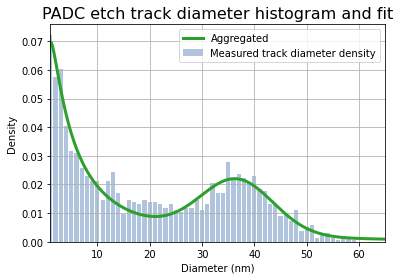

In [14]:
lopt = lognormal(dh, aopt, bopt, Alopt)
gopt = gaussian(dh, muopt, sigmaopt, Agopt)
w = lopt + gopt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('PADC etch track diameter histogram and fit', fontsize=16)
ax.set_xlabel('Diameter (nm)')
ax.set_ylabel('Density')
ax.set_xlim(xmin=1, xmax=65)
ax.bar(diameter, data['y'], color='lightsteelblue')
ax.plot(dh, w, '-', linewidth=3, color='tab:green')
ax.grid()
ax.legend(['Aggregated', 'Measured track diameter density'])
plt.show()

**Figure 3**: Histogram with aggregated fit.

The plot below in Figure 4 shows the unfolded fit, in red the log-Normal distribution and blue the Normal one:

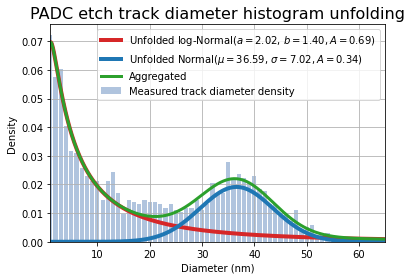

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('PADC etch track diameter histogram unfolding', fontsize=16)
ax.set_xlabel('Diameter (nm)')
ax.set_ylabel('Density')
ax.set_xlim(xmin=1, xmax=65)
ax.bar(diameter, data['y'], color='lightsteelblue')
ax.plot(dh, lopt, '-', linewidth=4, color='tab:red')
ax.plot(dh, gopt, '-', linewidth=4, color='tab:blue')
ax.plot(dh, w, '-', linewidth=3, color='tab:green')
ax.grid()
glab = 'Unfolded Normal($\\mu=%1.2f$, $\\sigma=%1.2f, A=%1.2f$)' % (muopt, sigmaopt, Agopt)
llab = 'Unfolded log-Normal($a=%1.2f$, $b=%1.2f, A=%1.2f$)' % (aopt, bopt, Alopt)
ax.legend([llab, glab, 'Aggregated', 'Measured track diameter density'])
plt.show()

**Figure 4**: Aggregated model used for the fitting (green curve) and unfolded models (blue and red curves).
Optimal parameter values are ported in the legend.

Finally, clean up and destroy the handle

In [16]:
# Destroy the handle:
opt.handle_free(handle)